# imports

In [68]:
# load and autoreload
from IPython import get_ipython


# this automatically updates changes in other file's funcionts. 
# it is very handy for data exploration
try:
    _magic = get_ipython().run_line_magic
    _magic('load_ext', 'autoreload')
    _magic('autoreload', '2')
except:
    pass


# import most used packages
import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import bnn_tools

In [70]:
# import customs functions

import bnn_tools.funs as fu
import bnn_tools.bnn_array
import bnn_tools.coag_sink as cs
import bnn_tools.basic_funs as bfu

# open sum nais file 

In [102]:
_p = os.path.dirname(
    os.path.dirname(bnn_tools.__path__[0])
)

_p


'/Users/aliaga/Documents/Work_DA/Py-packs/bnn-tools-repo'

In [103]:
p = os.path.join(_p,'example_data/NAISn20220515np.sum')
# dataset (xarray) of the sum data. 
ds = fu.open_sum2ds(p)

In [104]:
pp = os.path.join(_p,'example_data/izanapsm2022_inv_kernel_20220515.dat')

In [73]:
ds_psm = fu.open_psm2ds(pp)

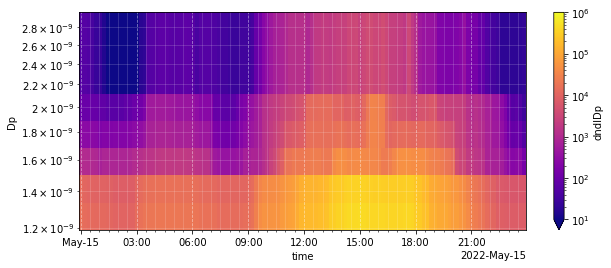

In [74]:
ds_psm.bnn.plot_psd()

# open smsp 

In [105]:
p3 = os.path.join(_p,'example_data/202205101400_SMPS.txt')

In [76]:
ds_s = fu.open_smps2ds(p3).loc[{'time':'2022-05-15'}]

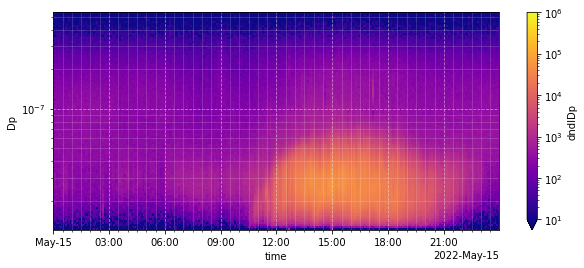

In [77]:
ds_s.bnn.plot_psd()

# combine two along DP

In [78]:
ts = 300
dpr = .05
Dp_cut = 3e-9
Dp_cut1 = 20e-9


dsn1 = ds.bnn.resample_ts(ts)[['dndlDp']]

dsn2 = dsn1.bnn.dp_regrid(10,dpr)

dsp1 = ds_psm.bnn.upsample_ts(ts).bnn.set_Dp()

dsp2 = dsp1.bnn.dp_regrid(10,dpr)


dss1 = ds_s.bnn.upsample_ts(ts)[['dndlDp']]


dss2 = dss1.bnn.dp_regrid(10,dpr)

In [79]:
dc = fu.combine_2_spectras(dsp2,dsn2,cut_dim='lDp',cut_point=np.log10(Dp_cut))

dc1 = fu.combine_2_spectras(dc,dss2,cut_dim='lDp',cut_point=np.log10(Dp_cut1))

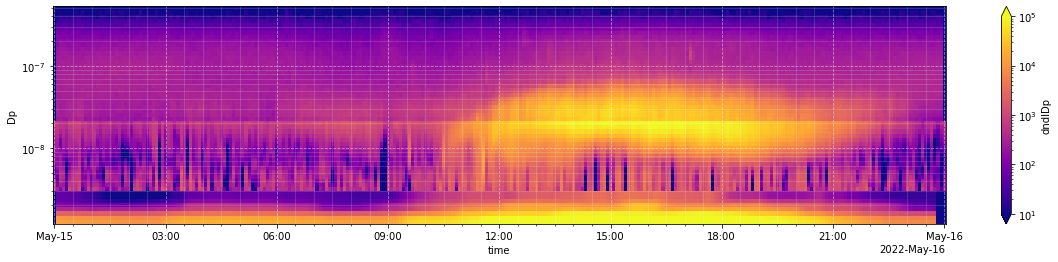

In [229]:
dc1.bnn.plot_psd(vmax=1e5)
f = plt.gcf()
f.set_figwidth(20)

In [81]:
# dc in m3 
dcM = dc1 * 1e6

In [82]:
T = 270 
P = 100000

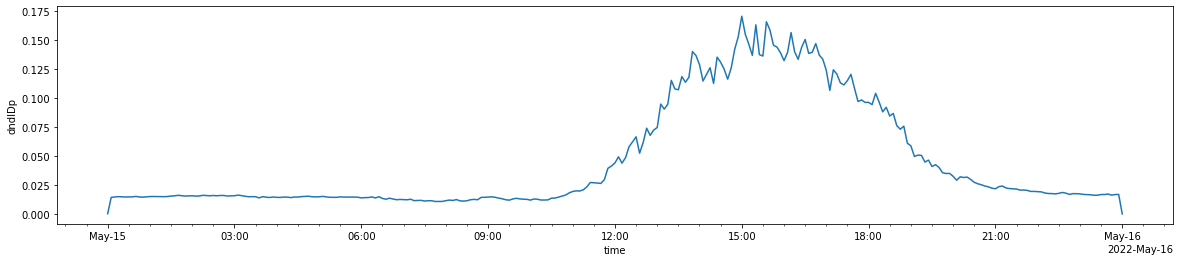

In [85]:
def _plt():
    dcM1 = dcM.bnn.set_Dp()
    cs_ = cs.calc_CS(dcM1,T,P)
    cs_['dndlDp'].bnn.set_time().plot()
    f = plt.gcf()
    f.set_figwidth(20)
    bfu.format_ticks(plt.gca())
_plt()

try again but now with particles from 10 to 1000nm

In [200]:
dcM1 = dcM.bnn.set_Dp().loc[{'Dp':slice(d1,d2)}]

In [215]:

dN_m3

<xarray.DataArray 'dN' (Dp: 53, secs: 289)>
array([[           nan, 7.13529103e+14, 6.75738481e+14, ...,
                   nan,            nan,            nan],
       [           nan, 5.62635463e+14, 5.33268558e+14, ...,
                   nan,            nan,            nan],
       [           nan, 1.31315749e+14, 1.25878442e+14, ...,
                   nan,            nan,            nan],
       ...,
       [           nan, 6.40284319e+11, 8.43449713e+11, ...,
        1.44745699e+12, 1.28482743e+12,            nan],
       [           nan, 4.05534964e+11, 4.49661866e+11, ...,
        4.80343101e+11, 4.69846139e+11,            nan],
       [           nan, 5.46854688e+11, 2.97124825e+11, ...,
        3.42974098e+11, 2.05210142e+11,            nan]])
Coordinates:
  * secs     (secs) float64 1.653e+09 1.653e+09 ... 1.653e+09 1.653e+09
    lDp      (Dp) float64 -8.9 -8.85 -8.8 -8.75 -8.7 ... -6.45 -6.4 -6.35 -6.3
  * Dp       (Dp) float64 1.259e-09 1.413e-09 1.585e-09 ... 4.467e-07 5.012e-07
    dlDp     (Dp) float64 0.05 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05 0.05 0.05
    dN       (Dp, secs) float64 nan 7.135e+08 6.757e+08 ... 2.052e+05 nan

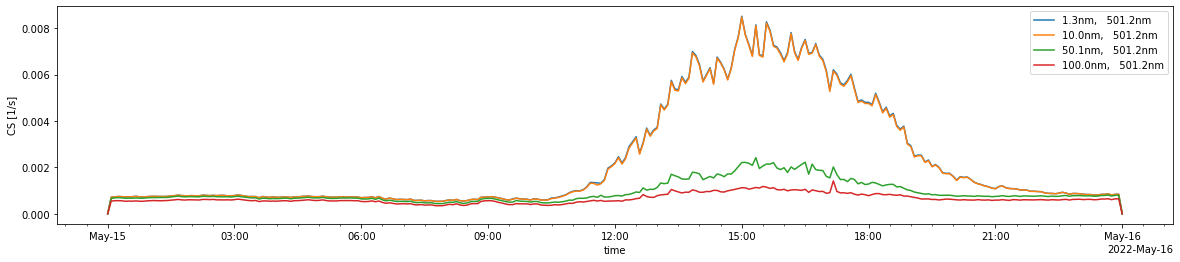

In [228]:
def _plt1(d1_,d2_):
    
    dN, d1,d2 = dcM.bnn.get_dN(d1_,d2_)
    dN_m3 = dN 
    

    cs_ = cs.calc_CS(dN_m3=dN_m3,P=P,T=T)
    cs_.bnn.set_time().plot(label=f'{d1*1e9:.1f}nm,   {d2*1e9:.1f}nm')
    ax = plt.gca()
    ax.legend()
    bfu.format_ticks(ax)
    f = plt.gcf()
    f.set_figwidth(20)

_plt1(1e-9,1000e-9)
_plt1(10e-9,1000e-9)
_plt1(50e-9,1000e-9)
_plt1(100e-9,1000e-9)


In [ ]:
xr.DataArray.

In [175]:
dcM1,d1,d2 = dcM.bnn.set_Dp()['dndlDp'].bnn.get_dN(0,1)

In [180]:
dens1 = dens2 = 1200 
alpha = 1 
dN = dcM1
d1 = 1e-9
d2 = 2e-9

In [181]:
_r = cs.calc_coag_snk_xr(dN_tot_m3 = dN , d1 = d1, d2 = d2 , P = P, T = T , alpha = alpha, dens1 = dens1, dens2 = dens2)

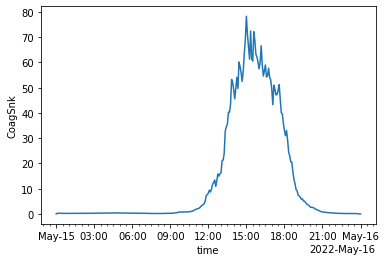

In [182]:
__r = _r['CoagSnk'].bnn.set_time()/1e6



__r.bnn.set_time().plot()
bfu.format_ticks(plt.gca())

In [183]:
_r['CoagSnk']

<xarray.DataArray 'CoagSnk' (secs: 289)>
array([       0.        ,   253571.27601047,   245939.84829136,
         238477.04328575,   229042.72271349,   217922.58855944,
         219523.44664151,   218449.32332116,   222246.67275408,
         212821.09253775,   207867.00636302,   208978.9520429 ,
         210566.13492714,   211020.4530183 ,   210518.90031694,
         208300.97230861,   207535.45275215,   207182.71079229,
         205910.12305009,   202345.07957334,   201557.35962431,
         193307.23471831,   186353.69067253,   185915.6232547 ,
         184313.73391953,   179627.53378481,   180808.77640801,
         188445.14570461,   186979.50387961,   183902.62820462,
         186887.09713977,   183922.47931032,   187049.57005612,
         187658.75095461,   187486.48125017,   218645.07682542,
         251916.96475851,   283428.13137554,   292961.89247778,
         299888.80974984,   314390.19614252,   334088.33057462,
         341164.73441644,   322173.88710622,   350856.06709433,
         345625.77121763,   343395.38339645,   353308.66910589,
         348288.86713865,   348312.93553654,   359943.88415675,
         356982.66125215,   348380.74975299,   363407.17767781,
         363561.25932295,   372220.33347839,   378101.49198039,
         381709.96310106,   370829.27166154,   364861.50737184,
...
        6581618.58401802,  5822596.27256618,  5969467.82242632,
        5100550.65509357,  5057690.91882629,  4572434.61984991,
        3917813.82138407,  3673285.1310004 ,  3418464.72527213,
        2947033.26121918,  2545284.72186092,  2676063.02672422,
        2519089.24532792,  2335923.15098921,  2017980.72653025,
        1764591.46810112,  1604515.37235561,  1421743.24263   ,
        1202295.36037167,  1023683.22860836,   862526.97912437,
         733515.81474232,   721790.41064458,   695587.74204698,
         608651.93962182,   558088.14294931,   522555.73541291,
         487695.87005447,   439269.63443178,   407090.79056787,
         360650.09243449,   307839.24456185,   284013.36967942,
         259558.67608062,   248749.48680767,   234405.72677621,
         219655.04173126,   197642.71462973,   171415.16791754,
         172260.38623693,   177980.91930846,   172133.35103202,
         159880.28754616,   164651.54892674,   160935.2077071 ,
         156490.94402628,   150817.49044688,   149479.34052903,
         148737.63966319,   144246.09172292,   145159.85520701,
         148915.17023344,   147464.76445922,   151275.05338476,
         142934.91339358,        0.        ,        0.        ,
              0.        ])
Coordinates:
  * secs     (secs) float64 1.653e+09 1.653e+09 ... 1.653e+09 1.653e+09
Attributes:
    units:    #/m3